## Artigo 2

### Students’ Academic Performance and Engagement Prediction in a Virtual Learning Environment Using Random Forest with Data Balancing

In [ ]:
!pip -q install imbalanced-learn

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score,
    f1_score, roc_curve, precision_recall_curve, confusion_matrix, classification_report
)

from imblearn.over_sampling import SMOTE
import warnings; warnings.filterwarnings("ignore")

### 1) Ler os CSVs (Drive ou upload)

In [ ]:
USE_DRIVE = True
if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE = "/content/drive/MyDrive/Período 3/ia/AV-I/"
else:
    BASE = "/content/oulad"

def read_csv(name):
    return pd.read_csv(f"{BASE}/{name}.csv")

courses            = read_csv("courses")
assessments        = read_csv("assessments")
studentAssessment  = read_csv("studentAssessment")
studentInfo        = read_csv("studentInfo")
vle                = read_csv("vle")
studentVle         = read_csv("studentVle")

for n, df in [("courses", courses), ("assessments", assessments), ("studentAssessment", studentAssessment),
              ("studentInfo", studentInfo), ("vle", vle), ("studentVle", studentVle)]:
    print(n, df.shape)


Mounted at /content/drive
courses (22, 3)
assessments (206, 6)
studentAssessment (173912, 5)
studentInfo (32593, 12)
vle (6364, 6)
studentVle (10655280, 6)


### 2) Preparar rótulo e colunas úteis

In [ ]:
label_map = {'Fail':0, 'Withdrawn':0, 'Pass':1, 'Distinction':1}
studentInfo = studentInfo.copy()
studentInfo['y'] = studentInfo['final_result'].map(label_map).astype('int8')

KEY = ['code_module','code_presentation','id_student']

demo_cols = ['gender','age_band','imd_band','highest_education','disability','studied_credits','num_of_prev_attempts']
demo = studentInfo[KEY + ['y'] + demo_cols].copy()

### 3) Engenharia de atributos por janela (engajamento + notas)

*   Engajamento (VLE): cliques totais, dias ativos e cliques por tipo de atividade.
*   Avaliações: soma ponderada pelas weights, contagens e média.

In [ ]:
TOP_N_ACT = 10  # limitar para manter o DF leve e intuitivo

def feats_vle(cutoff):
    sv = studentVle[(studentVle['date'] >= 0) & (studentVle['date'] <= cutoff)].copy()
    sv = sv.merge(vle[['id_site','activity_type','code_module','code_presentation']],
                  on=['id_site','code_module','code_presentation'], how='left')
    sv['sum_click'] = sv['sum_click'].fillna(0)

    base = sv.groupby(KEY, as_index=False).agg(
        total_clicks=('sum_click','sum'),
        active_days=('date','nunique'),
        max_clicks_day=('sum_click','max')
    )

    top_acts = sv['activity_type'].value_counts().head(TOP_N_ACT).index
    pivot = (sv[sv['activity_type'].isin(top_acts)]
             .groupby(KEY + ['activity_type'])['sum_click'].sum()
             .unstack('activity_type').fillna(0).reset_index())
    pivot = pivot.rename(columns={c: f"clicks_{str(c).lower()}" for c in pivot.columns if c not in KEY})

    out = base.merge(pivot, on=KEY, how='left')
    out['mean_clicks_per_day'] = (out['total_clicks'] / out['active_days'].replace(0,np.nan)).fillna(0)
    return out

def feats_assess(cutoff):
    sa = studentAssessment[studentAssessment['date_submitted'] <= cutoff].copy()
    sa = sa.merge(assessments[['id_assessment','code_module','code_presentation','assessment_type','weight']],
                  on='id_assessment', how='left')

    # limitar aos alunos existentes no studentInfo (mesmo curso/apresentação)
    sa = sa.merge(studentInfo[KEY], on=['id_student','code_module','code_presentation'], how='inner')

    sa['score'] = sa['score'].clip(lower=0, upper=100)
    sa['weight'] = sa['weight'].fillna(0)
    sa['weighted_score'] = sa['score'] * sa['weight']/100.0

    agg = sa.groupby(KEY, as_index=False).agg(
        n_submissions=('id_assessment','nunique'),
        mean_score=('score','mean'),
        sum_weighted_score=('weighted_score','sum'),
        sum_weights=('weight','sum'),
        n_TMA=('assessment_type', lambda x: (x=='TMA').sum()),
        n_CMA=('assessment_type', lambda x: (x=='CMA').sum()),
        n_Exam=('assessment_type', lambda x: (x=='Exam').sum())
    )
    agg['cw_progress_pct'] = agg['sum_weights'].clip(upper=100)
    return agg

def build_dataset(cutoff):
    df = demo.merge(feats_vle(cutoff), on=KEY, how='left') \
             .merge(feats_assess(cutoff), on=KEY, how='left')
    # preencher NaNs numéricos com 0
    num_cols = df.select_dtypes(include=['int64','float64','int32','float32','Int64']).columns.tolist()
    num_cols = [c for c in num_cols if c not in ['y']]
    df[num_cols] = df[num_cols].fillna(0)

    # one-hot simples das demografias
    cat_cols = ['gender','age_band','imd_band','highest_education','disability']
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

    # 🔧 Remover as chaves do aluno-curso (não são features!)
    df = df.drop(columns=KEY, errors='ignore')
    return df

### 4) — Treino/Teste com e sem SMOTE (para cada janela)

In [ ]:
FAST = True

TOP_N_ACT = 6  # antes era 10

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score, f1_score,
    roc_curve, precision_recall_curve, confusion_matrix, classification_report
)
from imblearn.over_sampling import SMOTE

def train_eval_simple(X_train, X_test, y_train, y_test, with_smote=False, random_state=42):
    # Hiperparâmetros fixos (bons defaults para OULAD):
    # - n_estimators menor para acelerar
    # - max_depth moderado para não overfitar e ser rápido
    # - class_weight='balanced' reduz custo quando sem SMOTE
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=16,
        min_samples_split=4,
        min_samples_leaf=2,
        max_features='sqrt',
        bootstrap=True,
        n_jobs=-1,
        random_state=random_state,
        class_weight=('balanced' if not with_smote else None)
    )

    if with_smote:
        sm = SMOTE(random_state=random_state)
        X_train, y_train = sm.fit_resample(X_train, y_train)

    rf.fit(X_train, y_train)
    proba = rf.predict_proba(X_test)[:, 1]
    pred  = (proba >= 0.5).astype(int)

    return {
        'model': rf,
        'acc': accuracy_score(y_test, pred),
        'roc_auc': roc_auc_score(y_test, proba),
        'pr_auc': average_precision_score(y_test, proba),
        'f1': f1_score(y_test, pred),
        'proba': proba,
        'pred': pred
    }

def run_cutoff_fast(cutoff, random_state=42):
    data = build_dataset(cutoff)


    for c in ['code_module','code_presentation','id_student']:
        if c in data.columns:
            data = data.drop(columns=[c])

    y = data['y'].values
    X = data.drop(columns=['y'])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, stratify=y, random_state=random_state
    )


    res_plain = train_eval_simple(X_train, X_test, y_train, y_test, with_smote=False, random_state=random_state)


    return {
        'cutoff': cutoff,
        'plain': res_plain,
        'X_test': X_test, 'y_test': y_test
    }

if FAST:
    windows = [180, 230, 260]  # pode recolocar [120,150,180,210,230,260] depois
else:
    windows = [120, 150, 180, 210, 230, 260]

runs_fast = []
for w in windows:
    print(f"==> Rodando (rápido) janela {w} dias")
    out = run_cutoff_fast(w)
    runs_fast.append(out)

rows = []
for r in runs_fast:
    m = r['plain']
    rows.append({
        'cutoff_days': r['cutoff'],
        'Accuracy': round(m['acc'],4),
        'ROC_AUC': round(m['roc_auc'],4),
        'PR_AUC': round(m['pr_auc'],4),
        'F1': round(m['f1'],4),
    })
res_df_fast = pd.DataFrame(rows).sort_values('cutoff_days')
res_df_fast

==> Rodando (rápido) janela 180 dias
==> Rodando (rápido) janela 230 dias
==> Rodando (rápido) janela 260 dias


,cutoff_days,Accuracy,ROC_AUC,PR_AUC,F1
0,180,0.9099,0.9668,0.9514,0.9080
1,230,0.9279,0.9773,0.9673,0.9259
2,260,0.9423,0.9835,0.9757,0.9406


### 5) — Gráficos ROC/PR da melhor janela (por ROC-AUC com SMOTE)

In [ ]:
# Sem SMOTE
best_idx, best_auc = None, -1
for i, r in enumerate(runs_fast):
    auc = r['plain']['roc_auc']
    if auc > best_auc:
        best_auc, best_idx = auc, i

best_run = runs_fast[best_idx]
best_w   = best_run['cutoff']
print(f"Melhor janela SEM SMOTE: {best_w} dias (ROC_AUC={best_auc:.3f})")

# Com SMOTE
data = build_dataset(best_w)
for c in ['code_module','code_presentation','id_student']:
    if c in data.columns:
        data = data.drop(columns=[c])

y = data['y'].values
X = data.drop(columns=['y'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, stratify=y, random_state=42
)

res_smote = train_eval_simple(X_train, X_test, y_train, y_test, with_smote=True, random_state=42)

print({
    'cutoff_days': best_w,
    'Accuracy': round(res_smote['acc'],4),
    'ROC_AUC': round(res_smote['roc_auc'],4),
    'PR_AUC': round(res_smote['pr_auc'],4),
    'F1': round(res_smote['f1'],4),
})

Melhor janela SEM SMOTE: 260 dias (ROC_AUC=0.984)
{'cutoff_days': 260, 'Accuracy': 0.9432, 'ROC_AUC': np.float64(0.9834), 'PR_AUC': np.float64(0.9759), 'F1': 0.9416}


### 6) — Relatório e matriz de confusão da melhor janela

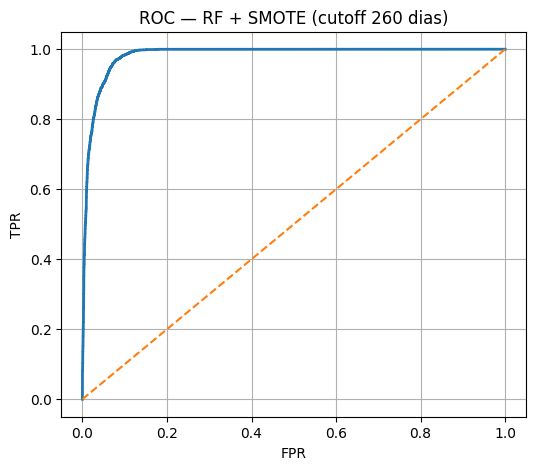

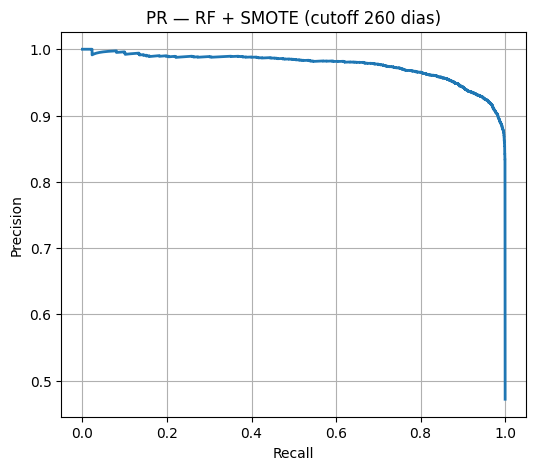

In [ ]:
# Gráficos ROC e PR da melhor janela com SMOTE
fpr, tpr, _ = roc_curve(y_test, res_smote['proba'])
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, lw=2); plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title(f'ROC — RF + SMOTE (cutoff {best_w} dias)')
plt.grid(True); plt.show()

prec, rec, _ = precision_recall_curve(y_test, res_smote['proba'])
plt.figure(figsize=(6,5))
plt.plot(rec, prec, lw=2)
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title(f'PR — RF + SMOTE (cutoff {best_w} dias)')
plt.grid(True); plt.show()

## Artigo 2 Melhoria do Modelo

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score, f1_score,
    roc_curve, precision_recall_curve, confusion_matrix
)

pd.set_option('display.max_columns', 200)
plt.rcParams['figure.figsize'] = (7,5)

### 1) Variaveis Importantes

In [ ]:
# Chave do aluno no curso
KEY = ['code_module','code_presentation','id_student']

# Rótulo binário (igual ao artigo)
label_map = {'Fail':0, 'Withdrawn':0, 'Pass':1, 'Distinction':1}
studentInfo = studentInfo.copy()
studentInfo['y'] = studentInfo['final_result'].map(label_map).astype('int8')

# Demografia simples
demo_cols = ['gender','age_band','imd_band','highest_education','disability','studied_credits','num_of_prev_attempts']
demo = studentInfo[KEY + ['y'] + demo_cols].copy()

### 2) Funções auxiliares

In [ ]:
def parse_presentation_order(code_presentation: str):
    """
    Converte algo como '2013B' ou '2014J' em tupla (ano, semestre),
    com B=1 (Feb), J=2 (Oct). Se vier só 'B'/'J', assume ano=0.
    """
    s = str(code_presentation)
    m = re.match(r"(\d{4})([BJ])", s)
    if m:
        year = int(m.group(1))
        sem = 1 if m.group(2) == 'B' else 2
        return (year, sem)
    # fallback: se não vier com ano (raro)
    sem = 1 if s.endswith('B') else 2 if s.endswith('J') else 0
    return (0, sem)

def winsorize_cols(df, cols, upper_q=0.99):
    """
    Cap no percentil superior para estabilizar outliers (winsorize simples).
    """
    for c in cols:
        if c in df.columns:
            cap = df[c].quantile(upper_q)
            df[c] = np.clip(df[c].values, a_min=None, a_max=cap)
    return df

def safe_ratio(num, den):
    den = np.where(den==0, 1, den)
    return num / den


### 3) Features BASE (replica: engajamento + avaliações + demografia)

In [ ]:
TOP_N_ACT = 6

def feats_vle_base(cutoff):
    # apenas dados até o cutoff
    sv = studentVle[(studentVle['date'] >= 0) & (studentVle['date'] <= cutoff)].copy()
    sv = sv.merge(vle[['id_site','activity_type','code_module','code_presentation']],
                  on=['id_site','code_module','code_presentation'], how='left')
    sv['sum_click'] = sv['sum_click'].fillna(0)

    base = sv.groupby(KEY, as_index=False).agg(
        total_clicks=('sum_click','sum'),
        active_days=('date','nunique'),
        max_clicks_day=('sum_click','max')
    )

    # tipos de atividade mais comuns
    top_acts = sv['activity_type'].value_counts().head(TOP_N_ACT).index
    pivot = (sv[sv['activity_type'].isin(top_acts)]
             .groupby(KEY + ['activity_type'])['sum_click'].sum()
             .unstack('activity_type').fillna(0).reset_index())
    pivot = pivot.rename(columns={c: f"clicks_{str(c).lower()}" for c in pivot.columns if c not in KEY})

    out = base.merge(pivot, on=KEY, how='left')
    out['mean_clicks_per_day'] = (out['total_clicks'] / out['active_days'].replace(0,np.nan)).fillna(0)
    return out

def feats_assess_base(cutoff):
    sa = studentAssessment[studentAssessment['date_submitted'] <= cutoff].copy()
    sa = sa.merge(assessments[['id_assessment','code_module','code_presentation','assessment_type','weight']],
                  on='id_assessment', how='left')
    sa = sa.merge(studentInfo[KEY], on=['id_student','code_module','code_presentation'], how='inner')

    sa['score'] = sa['score'].clip(lower=0, upper=100)
    sa['weight'] = sa['weight'].fillna(0)
    sa['weighted_score'] = sa['score'] * sa['weight']/100.0

    agg = sa.groupby(KEY, as_index=False).agg(
        n_submissions=('id_assessment','nunique'),
        mean_score=('score','mean'),
        sum_weighted_score=('weighted_score','sum'),
        sum_weights=('weight','sum'),
        n_TMA=('assessment_type', lambda x: (x=='TMA').sum()),
        n_CMA=('assessment_type', lambda x: (x=='CMA').sum()),
        n_Exam=('assessment_type', lambda x: (x=='Exam').sum())
    )

    agg['cw_progress_pct'] = agg['sum_weights'].clip(upper=100)

    agg['cw_score_norm'] = agg['sum_weighted_score'] / agg['sum_weights'].replace(0, np.nan)
    agg['cw_score_norm'] = agg['cw_score_norm'].fillna(0)
    agg['cw_missing_pct'] = (100 - agg['cw_progress_pct']).clip(lower=0)
    return agg

def build_dataset_base(cutoff):
    df = demo.merge(feats_vle_base(cutoff), on=KEY, how='left') \
             .merge(feats_assess_base(cutoff), on=KEY, how='left')

    # preencher NaNs numéricos com 0
    numeric_cols = df.select_dtypes(include=['int64','float64','int32','float32','Int64']).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c != 'y']
    df[numeric_cols] = df[numeric_cols].fillna(0)

    # one-hot simples da demografia
    cat_cols = ['gender','age_band','imd_band','highest_education','disability']
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)


    df = df.drop(columns=KEY, errors='ignore')
    return df


### 4) Recência de cliques (28d e 14d) + proporções e cap (winsorize)

In [ ]:
def feats_recency(cutoff, last_days=28):
    start = max(0, cutoff - last_days)
    sv = studentVle[(studentVle['date'] >= start) & (studentVle['date'] <= cutoff)].copy()
    sv['sum_click'] = sv['sum_click'].fillna(0)

    agg = sv.groupby(KEY, as_index=False).agg(
        clicks_last = ('sum_click','sum'),
        days_active_last = ('date','nunique'),
        max_clicks_day_last = ('sum_click','max')
    )
    agg = agg.rename(columns={
        'clicks_last': f'clicks_{last_days}d',
        'days_active_last': f'days_active_{last_days}d',
        'max_clicks_day_last': f'max_clicks_day_{last_days}d'
    })
    return agg

def add_recency_features(df_base, cutoff):

    df = df_base.copy()
    if 'total_clicks' not in df.columns:
        raise ValueError("total_clicks não encontrado no dataset base.")

    # 28d e 14d
    r28 = feats_recency(cutoff, 28)
    r14 = feats_recency(cutoff, 14)

    # merge
    tmp = demo[KEY].merge(r28, on=KEY, how='left').merge(r14, on=KEY, how='left')
    tmp = tmp.fillna(0)
    tmp = tmp.drop(columns=KEY)


    tmp['ratio_28d_total'] = safe_ratio(tmp['clicks_28d'].values, df['total_clicks'].values)
    tmp['ratio_14d_total'] = safe_ratio(tmp['clicks_14d'].values, df['total_clicks'].values)

    # winsorize nas colunas novas
    to_cap = [c for c in tmp.columns if c.startswith(('clicks_','days_active_','max_clicks','ratio_'))]
    tmp = winsorize_cols(tmp, to_cap, upper_q=0.99)

    # anexar ao base
    df = pd.concat([df.reset_index(drop=True), tmp.reset_index(drop=True)], axis=1)
    return df


### 5) Regularidade de cliques (std, cv, %dias ativos, gap_final, maior hiato)

In [ ]:
def feats_regularity(cutoff):

    sv = studentVle[(studentVle['date'] >= 0) & (studentVle['date'] <= cutoff)].copy()
    sv['sum_click'] = sv['sum_click'].fillna(0)
    daily = sv.groupby(KEY + ['date'], as_index=False)['sum_click'].sum()


    def _calc(group):

        days = group['date'].values.astype(int)
        clicks = group['sum_click'].values.astype(float)


        mean_day = clicks.mean() if len(clicks)>0 else 0.0
        std_day  = clicks.std(ddof=0) if len(clicks)>0 else 0.0
        cv = (std_day/mean_day) if mean_day>0 else 0.0


        pct_active_days = len(np.unique(days)) / max(cutoff,1)


        last_day = days.max() if len(days)>0 else -1
        gap_final = cutoff - last_day if last_day>=0 else cutoff


        if len(days)==0:
            longest_gap = cutoff
        else:

            arr = np.sort(np.unique(days))
            diffs = np.diff(np.concatenate([[-1], arr, [cutoff]]))

            gaps = diffs - 1
            longest_gap = int(gaps.max()) if len(gaps)>0 else 0

        return pd.Series({
            'mean_clicks_day': mean_day,
            'std_clicks_day': std_day,
            'cv_clicks_day': cv,
            'pct_active_days': pct_active_days,
            'gap_final_days': gap_final,
            'longest_inactive_streak': longest_gap
        })

    reg = daily.groupby(KEY).apply(_calc).reset_index()


    all_keys = demo[KEY].drop_duplicates()
    reg = all_keys.merge(reg, on=KEY, how='left').fillna({
        'mean_clicks_day':0.0,
        'std_clicks_day':0.0,
        'cv_clicks_day':0.0,
        'pct_active_days':0.0,
        'gap_final_days':cutoff,
        'longest_inactive_streak':cutoff
    })
    return reg

def add_regularity_features(df_base, cutoff):
    reg = feats_regularity(cutoff)
    reg = reg.drop(columns=KEY)
    reg = winsorize_cols(reg, reg.columns, upper_q=0.99)
    df = pd.concat([df_base.reset_index(drop=True), reg.reset_index(drop=True)], axis=1)
    return df


### 6) Construir BASELINE e IMPROVADO (Base + Recência + Regularidade)

In [ ]:
def build_dataset_improved(cutoff):
    base = build_dataset_base(cutoff)
    step1 = add_recency_features(base, cutoff)
    step2 = add_regularity_features(step1, cutoff)
    return step2


### 7) Treino/Avaliação (3 seeds médias) e Hold-out temporal por apresentação

In [ ]:
def train_eval_rf(X_train, X_test, y_train, y_test):
    # RF leve e estável sem SMOTE
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=16,
        min_samples_split=4,
        min_samples_leaf=2,
        max_features='sqrt',
        bootstrap=True,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    )
    rf.fit(X_train, y_train)
    proba = rf.predict_proba(X_test)[:,1]
    pred = (proba >= 0.5).astype(int)
    return dict(
        acc = accuracy_score(y_test, pred),
        roc_auc = roc_auc_score(y_test, proba),
        pr_auc  = average_precision_score(y_test, proba),
        f1      = f1_score(y_test, pred)
    )

def evaluate_windows(cutoffs=[180,230,260], seeds=[17,23,42], improved=False):
    rows = []
    for w in cutoffs:

        df = build_dataset_improved(w) if improved else build_dataset_base(w)
        y = df['y'].values
        X = df.drop(columns=['y'])


        m = []
        for sd in seeds:
            X_tr, X_te, y_tr, y_te = train_test_split(
                X, y, test_size=0.33, stratify=y, random_state=sd
            )
            m.append(train_eval_rf(X_tr, X_te, y_tr, y_te))

        avg = pd.DataFrame(m).mean(numeric_only=True).to_dict()
        rows.append(dict(cutoff_days=w, setting=('IMPROVED' if improved else 'BASELINE'), **{k: round(v,4) for k,v in avg.items()}))
    return pd.DataFrame(rows)

def evaluate_holdout(cutoff, improved=False):


    order = (demo[['code_presentation']].drop_duplicates()
             .assign(_ord=lambda d: d['code_presentation'].apply(parse_presentation_order))
             .sort_values('_ord'))
    last = order.iloc[-1]['code_presentation']


    base = build_dataset_improved(cutoff) if improved else build_dataset_base(cutoff)

    tmp = demo[KEY + ['y']].copy()
    tmp = pd.get_dummies(tmp, columns=['gender','age_band','imd_band','highest_education','disability'], drop_first=True) if False else tmp  # no-op

    tmp = tmp.reset_index(drop=True)
    base = base.reset_index(drop=True)
    assert len(tmp)==len(base), "Comprimento diferente — cheque merges."

    mask_test = (tmp['code_presentation'] == last).values
    y = base['y'].values
    X = base.drop(columns=['y'])

    X_train, y_train = X[~mask_test], y[~mask_test]
    X_test,  y_test  = X[mask_test],  y[mask_test]

    if len(y_test)==0 or len(y_train)==0:
        return None

    res = train_eval_rf(X_train, X_test, y_train, y_test)
    return dict(cutoff_days=cutoff, setting=('IMPROVED_HOLDOUT' if improved else 'BASELINE_HOLDOUT'),
                **{k: round(v,4) for k,v in res.items()})


### 8) Rodar avaliações e mostrar tabelas e gráfico de acurácia

In [ ]:
# 3 janelas para ficar leve (você pode recolocar [120,150,180,210,230,260] depois)
CUTS = [180, 230, 260]

# Baseline (réplica simplificada)
df_base = evaluate_windows(cutoffs=CUTS, improved=False)
# Garantir colunas padrão
if 'Variant' not in df_base.columns:
    df_base['Variant'] = 'BASE'
if 'Split' not in df_base.columns:
    df_base['Split'] = 'random_3seeds'


df_imp = evaluate_windows(cutoffs=CUTS, improved=True)
if 'Variant' not in df_imp.columns:
    df_imp['Variant'] = 'IMPROVED'
if 'Split' not in df_imp.columns:
    df_imp['Split'] = 'random_3seeds'


hold_base = evaluate_holdout(cutoff=260, improved=False)
hold_imp  = evaluate_holdout(cutoff=260, improved=True)

rows_hold = []
if hold_base is not None:
    if isinstance(hold_base, dict):
        hold_base.setdefault('Variant', 'BASE')
        hold_base.setdefault('Split', 'holdout_temporal')
        rows_hold.append(hold_base)
    else:
        hb = hold_base.copy()
        if 'Variant' not in hb.columns: hb['Variant'] = 'BASE'
        if 'Split' not in hb.columns:   hb['Split']   = 'holdout_temporal'
        rows_hold.append(hb)

if hold_imp is not None:
    if isinstance(hold_imp, dict):
        hold_imp.setdefault('Variant', 'IMPROVED')
        hold_imp.setdefault('Split', 'holdout_temporal')
        rows_hold.append(hold_imp)
    else:
        hi = hold_imp.copy()
        if 'Variant' not in hi.columns: hi['Variant'] = 'IMPROVED'
        if 'Split' not in hi.columns:   hi['Split']   = 'holdout_temporal'
        rows_hold.append(hi)

dfs = [df_base, df_imp]
if rows_hold:
    import pandas as pd
    dfs.append(pd.DataFrame(rows_hold))

df_all = pd.concat(dfs, ignore_index=True)

name_map = {
    'cutoff': 'cutoff_days',
    'cutoff_day': 'cutoff_days',
    'window': 'cutoff_days',
    'Accuracy': 'Accuracy',
    'ACC': 'Accuracy',
    'ROC_AUC': 'ROC_AUC',
    'AUC': 'ROC_AUC',
    'PR_AUC': 'PR_AUC',
    'F1': 'F1',
}
for old, new in list(name_map.items()):
    if old in df_all.columns and new not in df_all.columns:
        df_all.rename(columns={old: new}, inplace=True)

if 'cutoff_days' in df_all.columns:
    df_all['cutoff_days'] = df_all['cutoff_days'].astype(int)
for m in ['Accuracy','ROC_AUC','PR_AUC','F1']:
    if m in df_all.columns:
        df_all[m] = df_all[m].astype(float)

cols_show = [c for c in ['cutoff_days','Variant','Split','Accuracy','ROC_AUC','PR_AUC','F1'] if c in df_all.columns]
df_all = df_all.sort_values(['Split','Variant','cutoff_days']).reset_index(drop=True)

print("==== RESULTADOS (média de 3 seeds + hold-out temporal quando disponível) ====")
display(df_all[cols_show] if cols_show else df_all)

try:
    df_all.to_csv('resultados_oulad_rf_recencia_regularidade.csv', index=False)
    print("Arquivo salvo: resultados_oulad_rf_recencia_regularidade.csv")
except Exception as e:
    print("Falha ao salvar CSV (opcional):", e)


==== RESULTADOS (média de 3 seeds + hold-out temporal quando disponível) ====


,cutoff_days,Variant,Split
0,260,BASE,holdout_temporal
1,260,IMPROVED,holdout_temporal
2,180,BASE,random_3seeds
3,230,BASE,random_3seeds
4,260,BASE,random_3seeds
5,180,IMPROVED,random_3seeds
6,230,IMPROVED,random_3seeds
7,260,IMPROVED,random_3seeds


Arquivo salvo: resultados_oulad_rf_recencia_regularidade.csv


In [ ]:
import pandas as pd

required_targets = {
    'cutoff_days': ['cutoff_days', 'cutoff', 'cutoff_day', 'window'],
    'Variant':     ['variant', 'setting', 'model'],
    'Split':       ['split', 'fold_type'],
    'Accuracy':    ['accuracy', 'acc'],
    'ROC_AUC':     ['roc_auc', 'auc', 'roc'],
    'PR_AUC':      ['pr_auc', 'ap', 'average_precision', 'prauc'],
    'F1':          ['f1', 'f1_score']
}

def standardize_columns(df, mapping):
    # cria um mapa de renome robusto
    rename_map = {}
    lower_cols = {c.lower(): c for c in df.columns}
    for target, candidates in mapping.items():
        for cand in candidates:
            if cand in lower_cols:
                rename_map[ lower_cols[cand] ] = target
                break
    if rename_map:
        df = df.rename(columns=rename_map)
    return df

# padroniza nomes
df_all = standardize_columns(df_all, required_targets)

# garante que CUTS exista (caso tenha reiniciado kernel)
try:
    CUTS
except NameError:
    CUTS = [180, 230, 260]

# garante tipos e valores padrão
if 'cutoff_days' in df_all.columns:
    df_all['cutoff_days'] = pd.to_numeric(df_all['cutoff_days'], errors='coerce').astype('Int64')

# se Variant não existe, cria com rótulo “DESCONHECIDO”
if 'Variant' not in df_all.columns:
    df_all['Variant'] = 'DESCONHECIDO'

# normaliza valores comuns em Variant (opcional)
df_all['Variant'] = df_all['Variant'].astype(str).str.upper().replace({
    'BASELINE':'BASE', 'NO_SMOTE':'BASE',
    'IMPROVED':'IMPROVED', 'WITH_SMOTE':'IMPROVED'
})

# se Split não existe, assume random_3seeds (para plote)
if 'Split' not in df_all.columns:
    df_all['Split'] = 'random_3seeds'

# força métricas para float se existirem
for m in ['Accuracy','ROC_AUC','PR_AUC','F1']:
    if m in df_all.columns:
        df_all[m] = pd.to_numeric(df_all[m], errors='coerce')

print("Colunas após padronização:", list(df_all.columns))
try:
    display(df_all.head(10))
except:
    pass


Colunas após padronização: ['cutoff_days', 'setting', 'Accuracy', 'ROC_AUC', 'PR_AUC', 'F1', 'Variant', 'Split']


,cutoff_days,setting,Accuracy,ROC_AUC,PR_AUC,F1,Variant,Split
0,260,BASELINE_HOLDOUT,0.9498,0.9861,0.9822,0.9492,BASE,holdout_temporal
1,260,IMPROVED_HOLDOUT,0.9499,0.9873,0.9829,0.9494,IMPROVED,holdout_temporal
2,180,BASELINE,0.9096,0.9667,0.9530,0.9078,BASE,random_3seeds
3,230,BASELINE,0.9287,0.9776,0.9681,0.9269,BASE,random_3seeds
4,260,BASELINE,0.9447,0.9850,0.9795,0.9432,BASE,random_3seeds
5,180,IMPROVED,0.9169,0.9699,0.9574,0.9157,IMPROVED,random_3seeds
6,230,IMPROVED,0.9397,0.9824,0.9752,0.9384,IMPROVED,random_3seeds
7,260,IMPROVED,0.9508,0.9869,0.9817,0.9494,IMPROVED,random_3seeds


### 9) - Gráfico — Acurácia por janela (Baseline vs Improved) + marcadores do Hold-out

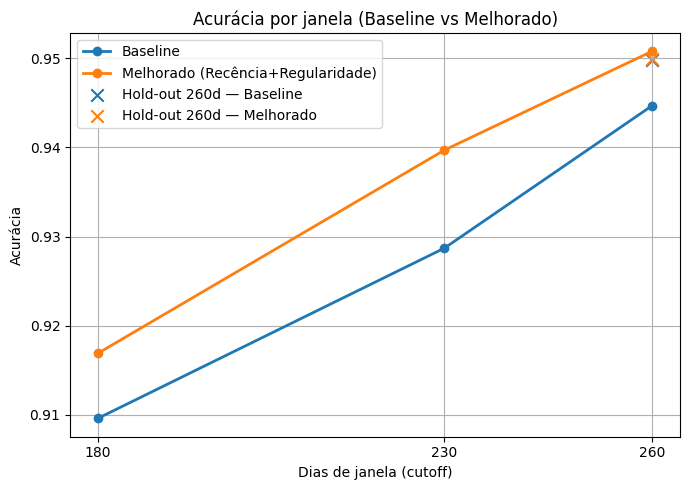

In [ ]:
import matplotlib.pyplot as plt

# Filtrar apenas os splits aleatórios (3 seeds) para as linhas
df_plot = df_all.copy()
if 'Split' in df_plot.columns:
    df_plot = df_plot[df_plot['Split'] == 'random_3seeds']

needed = {'cutoff_days','Variant','Accuracy'}
if needed.issubset(df_plot.columns) and not df_plot.empty:
    # Pivot com média por janela
    pivot_acc = df_plot.pivot_table(index='cutoff_days', columns='Variant', values='Accuracy', aggfunc='mean')

    # Reindexar para manter ordem CUTS (só nos que existem no pivot)
    idx = [c for c in CUTS if c in pivot_acc.index.tolist()]
    pivot_acc = pivot_acc.reindex(idx)

    if pivot_acc.empty:
        print("Sem linhas para plotar após reindex. Confira se df_all contém dados para CUTS:", CUTS)
    else:
        plt.figure(figsize=(7,5))
        if 'BASE' in pivot_acc.columns:
            plt.plot(pivot_acc.index, pivot_acc['BASE'], marker='o', linewidth=2, label='Baseline')
        if 'IMPROVED' in pivot_acc.columns:
            plt.plot(pivot_acc.index, pivot_acc['IMPROVED'], marker='o', linewidth=2, label='Melhorado (Recência+Regularidade)')

        # Overlay dos pontos de hold-out (se existirem)
        if {'Split','cutoff_days','Variant','Accuracy'}.issubset(df_all.columns):
            df_hold = df_all[(df_all['Split'] == 'holdout_temporal') & (df_all['cutoff_days'] == 260)]
            for var, mark in [('BASE','x'), ('IMPROVED','x')]:
                sub = df_hold[df_hold['Variant'].str.upper() == var]
                if not sub.empty and 'Accuracy' in sub.columns:
                    plt.scatter([260], [float(sub['Accuracy'].iloc[0])], marker=mark, s=80,
                                label=f'Hold-out 260d — { "Baseline" if var=="BASE" else "Melhorado" }')

        plt.title('Acurácia por janela (Baseline vs Melhorado)')
        plt.xlabel('Dias de janela (cutoff)')
        plt.ylabel('Acurácia')
        if len(idx) > 0:
            plt.xticks(idx)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
else:
    print("Colunas necessárias para o gráfico não estão presentes OU df_plot está vazio.")
    print("Precisamos de:", needed, "e temos:", set(df_plot.columns))
    print("Linhas em df_plot:", len(df_plot))

## Baseline x Melhorado (Recência + Regularidade)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, average_precision_score

BEST_CUTOFF = 260
RANDOM_STATE = 42

def _prep_xy(df):
    """Remove chaves (se existirem) e separa X,y."""
    for c in ['code_module','code_presentation','id_student']:
        if c in df.columns:
            df = df.drop(columns=[c])
    y = df['y'].values
    X = df.drop(columns=['y'])
    return X, y

def get_dataset_for_cutoff_base(cutoff):
    """Usa sua função de baseline (réplica)."""
    df = build_dataset_base(cutoff)
    return _prep_xy(df)

def get_dataset_for_cutoff_improved(cutoff):
    """Usa sua função melhorada (baseline + recência + regularidade)."""
    df = build_dataset_improved(cutoff)
    return _prep_xy(df)

def fit_and_proba_with_smote(X_train, y_train, X_test, random_state=RANDOM_STATE):

    rf = RandomForestClassifier(
        n_estimators=300, max_depth=16, min_samples_split=4, min_samples_leaf=2,
        max_features='sqrt', bootstrap=True, n_jobs=-1, random_state=random_state
    )
    sm = SMOTE(random_state=random_state)
    X_tr, y_tr = sm.fit_resample(X_train, y_train)
    rf.fit(X_tr, y_tr)
    proba = rf.predict_proba(X_test)[:, 1]
    return rf, proba

# ------------------ Baseline (réplica)
X_b, y_b = get_dataset_for_cutoff_base(BEST_CUTOFF)
Xb_tr, Xb_te, yb_tr, yb_te = train_test_split(
    X_b, y_b, test_size=0.33, stratify=y_b, random_state=RANDOM_STATE
)
model_base, proba_base = fit_and_proba_with_smote(Xb_tr, yb_tr, Xb_te, random_state=RANDOM_STATE)

# ------------------ Melhorado (Recência + Regularidade) — mesmo random_state
X_i, y_i = get_dataset_for_cutoff_improved(BEST_CUTOFF)
Xi_tr, Xi_te, yi_tr, yi_te = train_test_split(
    X_i, y_i, test_size=0.33, stratify=y_i, random_state=RANDOM_STATE
)
model_imp, proba_imp = fit_and_proba_with_smote(Xi_tr, yi_tr, Xi_te, random_state=RANDOM_STATE)

# Métricas-resumo para as legendas dos gráficos
roc_base = roc_auc_score(yb_te, proba_base)
pr_base  = average_precision_score(yb_te, proba_base)

roc_imp  = roc_auc_score(yi_te, proba_imp)
pr_imp   = average_precision_score(yi_te, proba_imp)

print({
    "cutoff": BEST_CUTOFF,
    "ROC_AUC_BASELINE": round(roc_base,4),
    "PR_AUC_BASELINE":  round(pr_base,4),
    "ROC_AUC_IMPROVED": round(roc_imp,4),
    "PR_AUC_IMPROVED":  round(pr_imp,4),
})


{'cutoff': 260, 'ROC_AUC_BASELINE': np.float64(0.9843), 'PR_AUC_BASELINE': np.float64(0.9782), 'ROC_AUC_IMPROVED': np.float64(0.9865), 'PR_AUC_IMPROVED': np.float64(0.981)}


## Gráficos ROC e PR (Baseline vs Melhorado) no cutoff escolhido

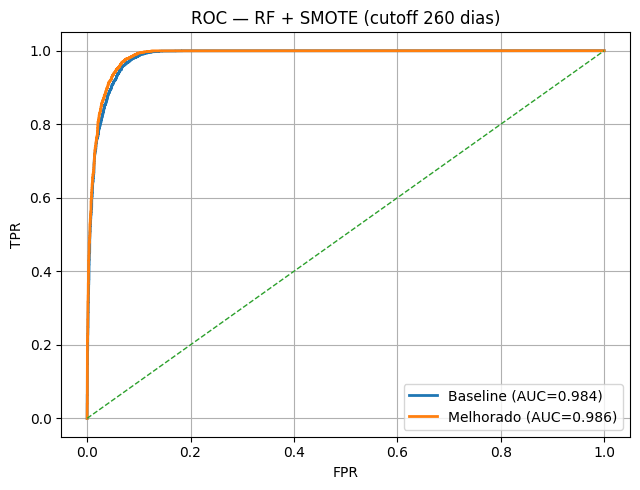

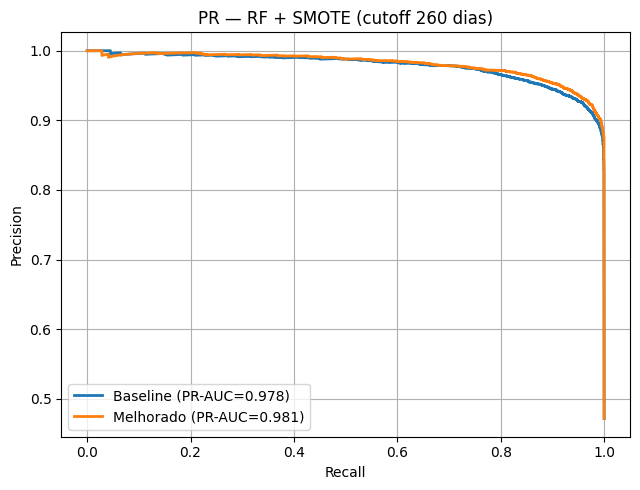

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

# -------- ROC
fpr_b, tpr_b, _ = roc_curve(yb_te, proba_base)
fpr_i, tpr_i, _ = roc_curve(yi_te, proba_imp)

plt.figure(figsize=(6.5,5))
plt.plot(fpr_b, tpr_b, linewidth=2, label=f'Baseline (AUC={roc_base:.3f})')
plt.plot(fpr_i, tpr_i, linewidth=2, label=f'Melhorado (AUC={roc_imp:.3f})')
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.title(f'ROC — RF + SMOTE (cutoff {BEST_CUTOFF} dias)')
plt.xlabel('FPR'); plt.ylabel('TPR')
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

# -------- PR
prec_b, rec_b, _ = precision_recall_curve(yb_te, proba_base)
prec_i, rec_i, _ = precision_recall_curve(yi_te, proba_imp)

plt.figure(figsize=(6.5,5))
plt.plot(rec_b, prec_b, linewidth=2, label=f'Baseline (PR-AUC={pr_base:.3f})')
plt.plot(rec_i, prec_i, linewidth=2, label=f'Melhorado (PR-AUC={pr_imp:.3f})')
plt.title(f'PR — RF + SMOTE (cutoff {BEST_CUTOFF} dias)')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()
